## Model evaluation

In [1]:
using Flux
using Plots
using DataFrames
using Printf
using BSON, JSON
using Arrow
using StatsBase
using Unicode
using Random

In [2]:
using Revise
using TokenizersLite
using TransformersLite

In [3]:
includet("reporting.jl")
includet("training.jl")

## Load data

raw

In [4]:
path = "path\\to\\amazon_reviews_multi\\en\\1.0.0\\"
file_train = "amazon_reviews_multi-train.arrow"
file_test = "amazon_reviews_multi-test.arrow" ;

In [5]:
checksum = readdir(path)[1]
filepath = joinpath(path, checksum, file_train)
df = DataFrame(Arrow.Table(filepath))

checksum = readdir(path)[1]
filepath = joinpath(path, checksum, file_test)
df_test = DataFrame(Arrow.Table(filepath));

In [6]:
nrow(df)

200000

transformed

In [7]:
documents = df[:, "review_body"]
labels = df[:, "stars"]

println("training samples: ", size(documents), " ", size(labels))

training samples: (200000,) (200000,)


test

In [8]:
documents_test = df_test[:, "review_body"]
labels_test = df_test[:, "stars"];

println("test samples: ", size(documents_test), " ", size(labels_test))

test samples: (5000,) (5000,)


## Tokenizers

In [9]:
vocab_directory = "..\\vocab\\bpe"
path_rules = joinpath(vocab_directory, "amazon_reviews_train_en_rules.txt")
path_vocab = joinpath(vocab_directory, "amazon_reviews_train_en_vocab.txt")
vocab = load_vocab(path_vocab)

@show tokenizer = load_bpe(path_rules, startsym="⋅")
#@show tokenizer = load_affix_tokenizer(path_vocab)
@show indexer = IndexTokenizer(vocab, "[UNK]")

tokenizer = load_bpe(path_rules, startsym = "⋅") = BytePairEncoder{String}(length(rules)=8000, length(cache)=0, unksym=[UNK], startsym=⋅, symbols=["##a", "##b", "##c", "##d", "##e", "##f", "##g", "##h", "##i", "##j", "##k", "##l", "##m", "##n", "##o", "##p", "##q", "##r", "##s", "##t", "##u", "##v", "##w", "##x", "##y", "##z", "⋅a", "⋅b", "⋅c", "⋅d", "⋅e", "⋅f", "⋅g", "⋅h", "⋅i", "⋅j", "⋅k", "⋅l", "⋅m", "⋅n", "⋅o", "⋅p", "⋅q", "⋅r", "⋅s", "⋅t", "⋅u", "⋅v", "⋅w", "⋅x", "⋅y", "⋅z", ",", ".", "?", "!", ":", ";", "\$", "€", "£", "&"])
indexer = IndexTokenizer(vocab, "[UNK]") = IndexTokenizer{String}(length(vocabulary)=7455, unksym=[UNK])


IndexTokenizer{String}(length(vocabulary)=7455, unksym=[UNK])

In [10]:
function clean(s::AbstractString)
    s = lowercase(s)
    s = Unicode.normalize(s, :NFD)
    s = replace(s, r"['`’\u200d\p{M}]" => "") # contractions, zero width joiner and marks from normalization
    s = replace(s, r"\n" => " ")
end

function preprocess(document, tokenizer; pattern = r"[A-Za-z][A-Za-z]+\b", max_length::Union{Nothing, Int}=nothing)
    document = clean(document)
    words = map(m->string(m.match), eachmatch(pattern, document))
    tokens = tokenizer(words)
    if !isnothing(max_length)
        if length(tokens) > max_length
            tokens = tokens[1:max_length]
        end
    end
    tokens
end

preprocess (generic function with 1 method)

In [11]:
max_length = 50

@time tokens = map(d->preprocess(d, tokenizer, max_length=50), documents) #takes about 30 seconds for all documents
@time indices = indexer(tokens) #takes about 12 seconds for all documents

y_train = copy(labels)
y_train[labels .≤ 2] .= 0
y_train[labels .≥ 4] .= 1
idxs = labels .!= 3
X_train, y_train = indices[:, idxs], y_train[idxs];
y_train = reshape(y_train, 1, :)
train_data, val_data = split_validation(X_train, y_train; rng=MersenneTwister(2718))

println("train samples:      ", size(train_data[1]), " ", size(train_data[2]))
println("validation samples: ", size(val_data[1]), " ", size(val_data[2]))

 87.918770 seconds (654.29 M allocations: 20.549 GiB, 7.45% gc time, 0.79% compilation time)
 36.658803 seconds (114.70 k allocations: 83.865 MiB, 0.33% compilation time)
train samples:      (50, 144000) (1, 144000)
validation samples: (50, 16000) (1, 16000)


In [12]:
y_test = copy(labels_test)
y_test[labels_test .≤ 2] .= 0
y_test[labels_test .≥ 4] .= 1
idxs = labels_test .!= 3
y_test = reshape(y_test[idxs], 1, :);

@time tokens_test = map(d->preprocess(d, tokenizer, max_length=max_length), documents_test) 
@time indices_test = indexer(tokens_test)

X_test = indices_test[:, idxs]

println("test indices: ", size(indices_test))
println("test samples: ", size(X_test), " ", size(y_test))

  1.269075 seconds (6.08 M allocations: 214.608 MiB, 5.79% gc time, 8.66% compilation time)
  0.862702 seconds (4 allocations: 1.946 MiB)
test indices: (50, 5000)
test samples: (50, 4000) (1, 4000)


## Evaluate

In [13]:
loss(x, y) = Flux.logitbinarycrossentropy(model(x), y)
loss(x::Tuple) = loss(x[1], x[2])

loss (generic function with 2 methods)

In [14]:
add_position_encoding(x) = x .+ PositionEncoding(32)(x) 

add_position_encoding (generic function with 1 method)

In [15]:
directory = "../outputs/20220519_1535"

BSON.@load joinpath(directory, "model.bson") model
model

TransformerClassifier(
     Embed(32, 7455),                   # 238_560 parameters
     PositionEncoding(32),
     Dropout(0.1),
     TransformerEncoderBlock(
          MultiheadAttention(num_heads=4, head_size=8, 32=>32)(
               denseQ = Dense(32 => 32),  # 1_056 parameters
               denseK = Dense(32 => 32),  # 1_056 parameters
               denseV = Dense(32 => 32),  # 1_056 parameters
               denseO = Dense(32 => 32),  # 1_056 parameters
          )
          Dropout(0.1),
          LayerNorm(32),                # 64 parameters
          Dense(32 => 128, relu),       # 4_224 parameters
          Dense(128 => 32),             # 4_128 parameters
          Dropout(0.1),
          LayerNorm(32),                # 64 parameters
     )
     Dense(32 => 1),                    # 33 parameters
     FlattenLayer(),
     Dense(50 => 1),                    # 51 parameters
)                  # Total: 21 arrays, 251_348 parameters, 1.082 MiB.

In [16]:
@time batched_metric(accuracy, train_data[1], train_data[2], g=model)

 70.056900 seconds (35.34 M allocations: 44.989 GiB, 8.79% gc time, 36.00% compilation time)


0.9039930555555552

In [17]:
@time batched_metric(accuracy, val_data[1], val_data[2], g=model)

  5.799789 seconds (3.11 k allocations: 4.793 GiB, 9.20% gc time)


0.878125

In [18]:
history = Dict()
open(joinpath(directory, "history.json"), "r") do f
    global history
    history=JSON.parse(read(f, String))
end

Dict{String, Any} with 4 entries:
  "train_loss" => Any[0.396013, 0.330704, 0.304764, 0.289531, 0.274037, 0.26764…
  "train_acc"  => Any[0.819701, 0.857681, 0.870917, 0.87775, 0.884451, 0.888771…
  "val_acc"    => Any[0.81525, 0.848938, 0.860375, 0.8675, 0.869813, 0.873563, …
  "val_loss"   => Any[0.401629, 0.342548, 0.31801, 0.309395, 0.30046, 0.300756,…

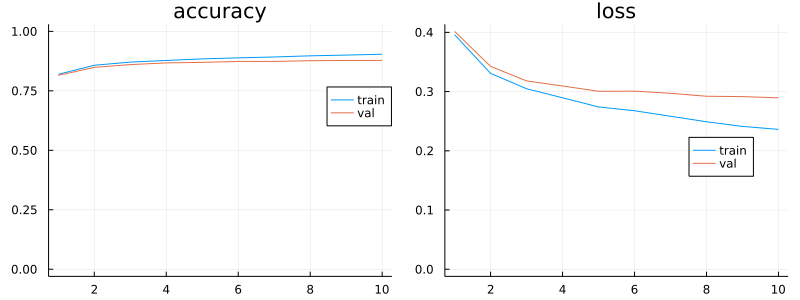

In [19]:
epochs = 1:length(history["train_acc"])
p1 = plot(epochs, history["train_acc"], label="train")
plot!(p1, epochs, history["val_acc"], label="val")
plot!(p1, ylims=[0, 1], title="accuracy", legend=(0.9, 0.7))

p2 = plot(epochs, history["train_loss"], label="train")
plot!(p2, epochs, history["val_loss"], label="val")
plot!(p2, title="loss", ylims=[0, Inf], legend=(0.8, 0.5))
plot(p1, p2, layout=grid(1, 2), size=(800, 300))

## Test data

In [20]:
logits = model(X_test)
@time accuracy(logits, y_test)

  0.500783 seconds (793.19 k allocations: 38.630 MiB, 99.98% compilation time)


0.87475

In [21]:
probs = σ.(logits)
y_pred = Int.(probs .> 0.5);

In [22]:
cm = confusion_matrix(vec(y_pred), vec(y_test), 0:1)

2×2 Matrix{Int64}:
 1777   223
  278  1722

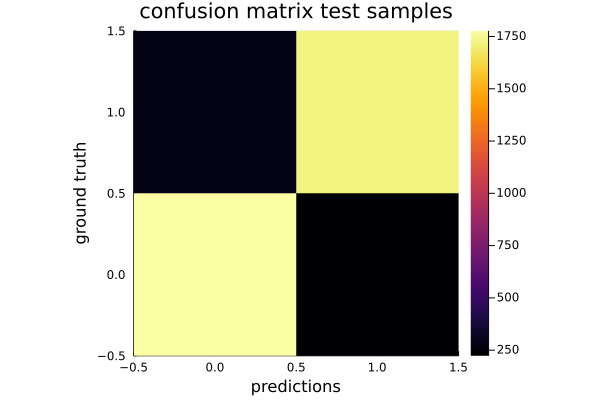

In [23]:
p = heatmap(0:1, 0:1, cm, xlabel="predictions", ylabel="ground truth", xlims=(-0.5,1.5), aspectratio=1, 
    title="confusion matrix test samples")
#savefig(p, "../outputs/confusion_matrix_regression.png")
p

In [24]:
classification_report(cm, 0:1)

              precision  recall  f1-score  support
           0       0.86    0.89      0.88     2000
           1       0.89    0.86      0.87     2000

weighted avg       0.88    0.87      0.87     4000

In [25]:
nshow = 3

for label in [0, 1]
    println("\ntrue label = $label")
    idxs = y_test .== label
    idxs_label = (1:size(y_test, 2))[vec(idxs)]
    idxs_wrong = idxs_label[y_pred[idxs] .!== label]
    println("#incorrect $(length(idxs_wrong))")
    for idx in sample(idxs_wrong, nshow, replace=false)
        println("$idx-$(y_test[idx])-$(y_pred[idx]) - ", documents_test[labels_test.!==3][idx])
    end
end


true label = 0
#incorrect 223
1204-0-1 - My friend recommended the mask of this line so I bought that, this conditioner, and the all in one milk. I cannot speak for the effectiveness of the product because the smell was just not tolerable. You know that musty smell old buildings use in female restrooms to try to mask the smell of *ladies* but it just turns out as this sour, chemical, kind of musty grandma smell? Ya that's all I can think of when I smell this. You know different strokes different folks so maybe you'll like the smell. My friend said it can help even the most damaged hair, so if you don't care about scent then no worries. I know natural products aren't going to smell as pretty as some synthetic ones but I feel like more and more natural lines just care less since it will sell anyway and so now everything just smells like playdough. I've lost a few favorite lines to them changing the formula to cheaper ingredients. I don't know if that's the case here or if this is a fake

## Probabilities for all labels

In [26]:
probs_all = σ.(model(indices_test));
y_pred_all = Int.(probs_all .> 0.5);

In [27]:
pos_max = argmax(probs_all)[2]
println(pos_max, " - ", labels_test[pos_max], " - ", y_pred_all[pos_max], " - ", 
        probs_all[pos_max], " - ", documents_test[pos_max])

pos_min = argmin(probs_all)[2]
println(pos_min, " - ", labels_test[pos_min], " - ", y_pred_all[pos_min], " - ", 
        probs_all[pos_min], " - ", documents_test[pos_min])

4164 - 5 - 1 - 0.9998621 - Love it exactly what I needed good quality
935 - 1 - 0 - 0.00012852592 - Crap! Totally not worth a penny.


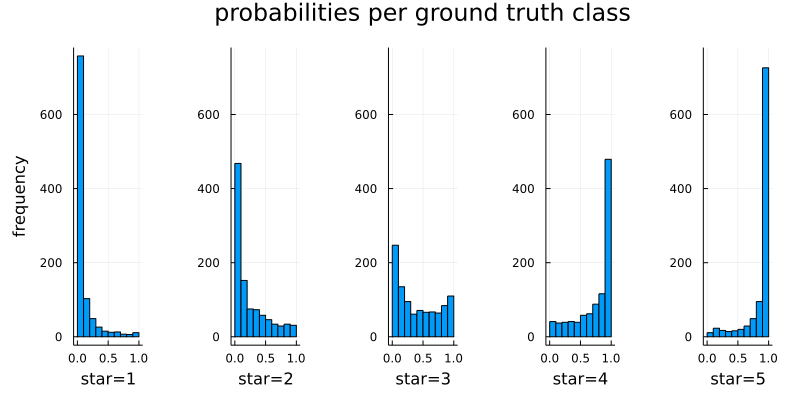

In [28]:
p = plot()
canvases = []
for star in 1:5
    idxs = labels_test .== star
    c = histogram(probs_all[idxs], label="", xticks=([0.00, 0.50, 1.00]), xlabel="star=$star", nbins=12)
    push!(canvases, c)
end
plot!(canvases[1], ylabel="frequency")
p = plot(canvases..., layout=(1, 5), link=:y, size=(800, 400), plot_title="probabilities per ground truth class",
    margin=5Plots.mm)
#savefig(p, "../outputs/probabilities_ground_truth.png")
p

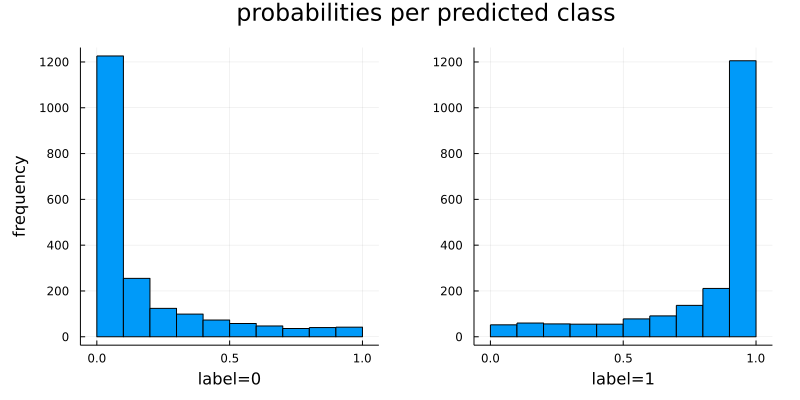

In [29]:
p = plot()
canvases = []
for label in 0:1
    idxs = y_test .== label
    c = histogram(probs[idxs], label="", xticks=([0.00, 0.50, 1.00]), xlabel="label=$label", nbins=12)
    push!(canvases, c)
end
plot!(canvases[1], ylabel="frequency")
p = plot(canvases..., layout=(1, 2), link=:y, size=(800, 400), plot_title="probabilities per predicted class",
    margin=5Plots.mm)
#savefig(p, "../outputs/probabilities_ground_truth.png")
p

In [30]:
nshow = 3

label = 5
println("true label = $label")
idxs = labels_test .== label
idxs_label = (1:length(labels_test))[vec(idxs)]
idxs_wrong = idxs_label[probs_all[idxs] .<= 0.1]
println("#incorrect $(length(idxs_wrong))")
for idx in sample(idxs_wrong, nshow, replace=false)
    println("$idx-$(labels_test[idx])-$(probs_all[idx]) - ", documents_test[idx])
end

println("")

label = 1
println("true label = $label")
idxs = labels_test .== label
idxs_label = (1:length(labels_test))[vec(idxs)]
idxs_wrong = idxs_label[probs_all[idxs] .>= 0.9]
println("#incorrect $(length(idxs_wrong))")
for idx in sample(idxs_wrong, nshow, replace=false)
    println("$idx-$(labels_test[idx])-$(probs_all[idx]) - ", documents_test[idx])
end

true label = 5
#incorrect 11
4942-5-0.0066511044 - I bought two sets. In White. One came with a couple light brown stains. Maybe dirt. Who knows. The lining plastic package was torn. Washed them immediately after arrival with TIDE & dirt removed! So I didn’t have to return it! The fabric does NOT puff up. Looks brand new even after wash! VERY SOFT! Wrinkle free as noted!!! Very white after washing with plain blue Tide detergent. Will buy again!!! AND AGAIN!! THANK YOU!!!
4701-5-0.08087632 - In the picture it looks shorter than it is. It’s not a crop top!
4770-5-0.058907937 - At first I thought I wouldn't like this wallet...but I was wrong...I like it alot

true label = 1
#incorrect 11
99-1-0.988427 - I love it It is adorable , perfect size! But my glass part has a crack, can you please replace the glass part? Thank you
322-1-0.9839098 - Fantastic belt ,love it . This is my second one , the first one was a little small but this one is perfect. I suggest you order one size bigger than yo

## Single samples

In [31]:
idx = 4700  

d = documents_test[idx]
println(labels_test[idx])
println(d)
tokens = preprocess(d, tokenizer, max_length=50)
println(join(tokens, "|"))
x = indexer(tokens)
x = vcat(x, ones(Int, 50 - length(x)))
println(join(x, "|"))

5
This makes almost the whole series. Roman Nights will be the last one. Loved them all. Alaskan Nights was awesome. Met my expectations , hot SEAL hero, beautiful & feisty woman. Filled with intrigue, steamy romance & nail biting ending. Have read two other books of yours. Am looking forward to more.
⋅this|⋅makes|⋅almost|⋅the|⋅whole|⋅series|⋅rom|##an|⋅nights|⋅will|⋅be|⋅the|⋅last|⋅one|⋅loved|⋅them|⋅all|⋅al|##ask|##an|⋅nights|⋅was|⋅awesome|⋅met|⋅my|⋅expectations|⋅hot|⋅seal|⋅hero|⋅beautiful|⋅fe|##ist|##y|⋅woman|⋅filled|⋅with|⋅intrig|##ue|⋅stea|##my|⋅romance|⋅nail|⋅bit|##ing|⋅ending|⋅have|⋅read|⋅two|⋅other|⋅books
8|242|306|2|475|633|5068|985|2849|44|28|2|167|27|235|32|37|1647|6812|985|2849|14|476|2962|11|1759|403|831|3469|347|2966|1578|269|1998|1521|17|4949|3152|4805|3813|2152|1626|137|124|1537|18|175|106|79|553


In [32]:
model.embed(x)

32×50 Matrix{Float32}:
  0.451905   -1.0538      0.171775   -2.91452     …  -0.579087    1.3963
 -0.792829    0.193514    0.460786   -0.650348       -0.326142   -0.420839
  0.886454   -0.0081291   1.37228    -0.622589        0.02159    -1.45605
  1.07562    -0.335118    1.47725    -1.09103        -1.43966     0.0748104
 -1.04559     1.16735    -0.711741   -0.993145       -2.06097    -0.987164
 -0.127467    1.04049     0.437017   -0.562423    …  -0.322139    0.335007
  0.12975     1.50486    -0.523657   -0.303724       -1.9308      0.304879
  1.13668     0.520456   -0.38724    -0.518437       -1.22686     0.407064
 -1.0201     -0.873765   -1.04285     0.470348        0.271599    0.925617
  0.551469    0.333771    1.50101    -0.451581       -0.347111    0.110244
  1.15174    -0.524977    1.33581    -0.420894    …  -0.480322   -0.155288
 -0.164869    1.63906     2.26624     0.00807137      0.0463646   0.363379
 -0.0905868   0.363127   -1.17672     0.330325        0.208343   -1.63416
  ⋮  

In [33]:
σ.(model(x))

1×1 Matrix{Float32}:
 0.9892966